### Импорт библиотек и датасетов

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [6]:
users = pd.read_csv('resources/users.tsv',sep='\t')
history = pd.read_csv('resources/history.tsv',sep='\t')
validate = pd.read_csv('resources/validate.tsv',sep='\t')
validate_answers = pd.read_csv('resources/validate_answers.tsv',sep='\t')

### Корреляция validate и validate_answers

#### Выделение, преобразование и удаление признаков

Для удобства обозначений

In [90]:
X = validate.copy()
Y = validate_answers.copy()

Выделение

In [91]:
X.insert(len(X.columns),
         'delay',
         X['hour_end']-X['hour_start'])

In [92]:
# количество площадок - задаем ручками

publishers_amount = 21

In [93]:
# Вытаскиваем фичи по пользователям

users_features = pd.DataFrame(columns=[
    'no_sex_prop',
    'no_age_prop',
    'city_count',
    'history_cpm_mean',
    'adv_shown_freq'
])

user_publishers_props = pd.DataFrame(columns=range(1,publishers_amount+1)) 

for index, row in X.iterrows():
    
    users_ids = [ int(i) for i in row['user_ids'].split(',')]

    users_info = users[
        users['user_id'].isin(users_ids)
    ]

    # анализируем, что попадается ЦА
    users_history_shown = history[(history['user_id'].isin(users_ids)) & (history['hour'] < row['hour_start'])]


    users_features.loc[index] = [
        (users_info['sex'] == 0).sum() / row['audience_size'], # no_sex_prop
        (users_info['age'] == 0).sum() / row['audience_size'], # no_age_prop
        len(users_info['city_id'].unique()), # city_count
        users_history_shown['cpm'].mean(), # history_cpm_mean
        users_history_shown['publisher'].count() / len(users_ids) if len(users_ids)>0 else 0 # adv_shown_freq
    ]

    # пользовательские фичи по площадкам
    user_publishers_props.loc[index] = users_history_shown['publisher'].value_counts(normalize=True)

user_publishers_props = user_publishers_props.fillna(0)

X = pd.concat([X, users_features], axis=1)


In [94]:
# вытаскиваем фичи по publishers

publishers_features = pd.DataFrame(columns=['p'+str(i) for i in range(1,publishers_amount+1)])

for index, row in X.iterrows():
    
    publishers = [int(i) for i in row['publishers'].split(',')]
    
    publishers_features.loc[index] = [int(i in publishers) for i in range(1,publishers_amount+1)]

publishers_features = user_publishers_props.values * publishers_features

X = pd.concat([X, publishers_features], axis=1)

In [95]:
# Вытаскиваем фичи времени

hours = pd.get_dummies((X['hour_start'] % 24), prefix='h')
week_day = pd.get_dummies((X['hour_start'] % 7), prefix='d')

X = pd.concat([X,hours,week_day],axis=1)

Среднее время между показами

In [96]:
# Вытаскиваем фичи по пользователям
users_features['avg_time_between_ads'] = 0.0

for index, row in X.iterrows():
    users_ids = [int(i) for i in row['user_ids'].split(',')]
    users_history_shown = history[(history['user_id'].isin(users_ids)) & (history['hour'] < row['hour_start'])]
    
    avg_time_between_ads = 0.0
    for user_id, group in users_history_shown.groupby('user_id'):
        hours = sorted(group['hour'].unique())
        if len(hours) > 1:
            avg_time_between_ads += np.mean(np.diff(hours))
    avg_time_between_ads /= len(users_ids) if len(users_ids) > 0 else 1
    users_features.at[index, 'avg_time_between_ads'] = avg_time_between_ads

# Объединяем с основным датасетом X
X = pd.concat([X, users_features[['avg_time_between_ads']]], axis=1)

Сессионная активность 

In [97]:
# Вытаскиваем фичи по пользователям
users_features['session_count'] = 0
users_features['avg_session_duration'] = 0.0
users_features['ads_per_session'] = 0.0

for index, row in X.iterrows():
    users_ids = [int(i) for i in row['user_ids'].split(',')]
    users_history_shown = history[(history['user_id'].isin(users_ids)) & (history['hour'] < row['hour_start'])]
    
    session_count = 0
    total_duration = 0
    ads_per_session = 0
    for user_id, group in users_history_shown.groupby('user_id'):
        group = group.sort_values('hour')
        sessions = []
        current_session = [group['hour'].iloc[0]]
        
        for hour in group['hour'].iloc[1:]:
            if hour - current_session[-1] > 6:
                sessions.append(current_session)
                current_session = [hour]
            else:
                current_session.append(hour)
        sessions.append(current_session)
        
        session_count += len(sessions)
        total_duration += sum(max(session) - min(session) for session in sessions)
        ads_per_session += len(group) / len(sessions) if sessions else 0
    
    users_features.at[index, 'session_count'] = session_count
    users_features.at[index, 'avg_session_duration'] = total_duration / session_count if session_count > 0 else 0
    users_features.at[index, 'ads_per_session'] = ads_per_session / session_count if session_count > 0 else 0

# Объединяем с основным датасетом X
session_columns = ['session_count', 'avg_session_duration', 'ads_per_session']
X = pd.concat([X, users_features[session_columns]], axis=1)
# X = pd.concat([X, users_features[avg_session_duration]], axis=1)

In [98]:
# Создаем новую фичу: общее время активности пользователя
X['total_session_time'] = X['session_count'] * X['avg_session_duration']

In [99]:
# Создаем новую фичу: остаточное время до следующего показа
X['remaining_time_to_next_ad'] = X['delay'] - X['avg_time_between_ads']

# Заполняем 0 (если avg_time_between_ads > delay)
X['remaining_time_to_next_ad'] = X['remaining_time_to_next_ad'].clip(lower=0)

Преобразование

In [ ]:
### можно добавить фильтрацию выбросов

In [100]:
X['publishers_count'] = X['publishers'].apply(lambda s: s.count(',')+1)

In [101]:
for column in X.columns: 
    if column in ['publishers', 'user_ids']:
        continue
    X[column] = (X[column] - X[column].mean()) / X[column].std() 

Удаление

In [ ]:
X_filtered = X[['p1',
       'remaining_time_to_next_ad',
       'delay',
       'cpm',
       'p2',
       'avg_session_duration',
       'history_cpm_mean',
       'adv_shown_freq']]

# Объединяем фильтрованный X с целевыми переменными Y для анализа корреляции
df_filtered = pd.concat([X_filtered, Y], axis=1)

#### Матрицы

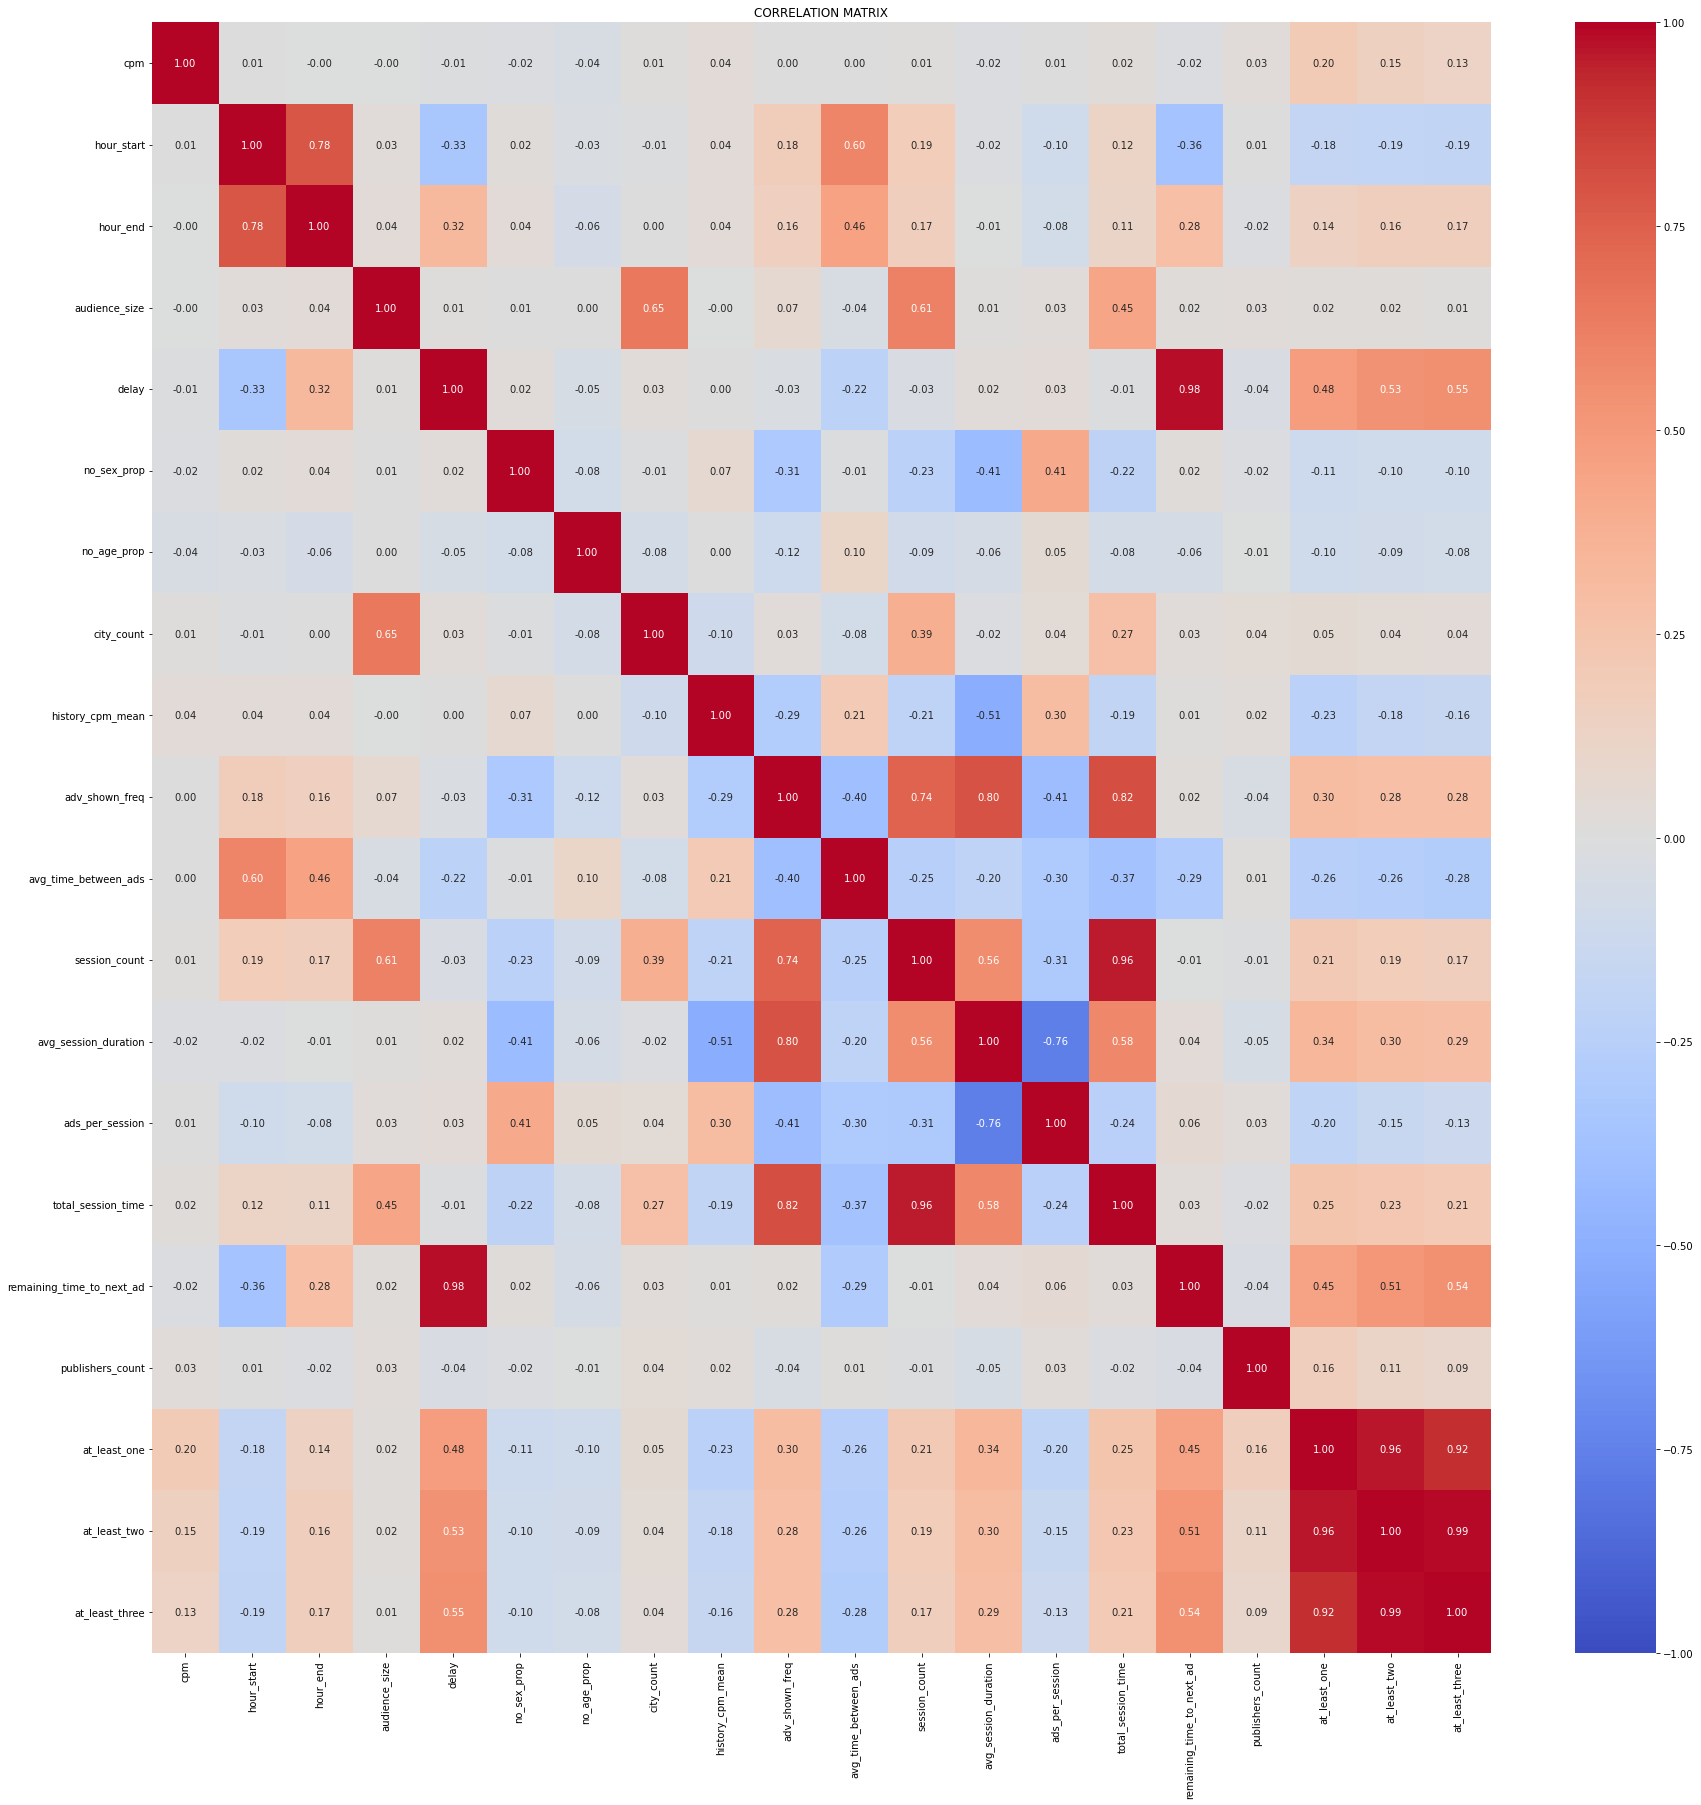

In [ ]:
# Настройка графика
f = plt.figure(facecolor='white')
f.set_figwidth(30)
f.set_figheight(30)

# Вычисление корреляционной матрицы
correlation_matrix = df_filtered.corr()

# Построение тепловой карты
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('CORRELATION MATRIX')
plt.show()

In [ ]:
pp = sns.pairplot(df_filtered,
             #x_vars = ['p1', 'history_cpm_mean'],
             #y_vars = ['at_least_one', 'at_least_two', 'at_least_three'],
             plot_kws = dict(alpha = 0.3),
             height = 2.5)
#pp.map(sns.regplot, scatter = False)
plt.show()

In [111]:
X.to_csv('features.tsv', sep='\t', index=False)